Train raw size: 1006, Val raw size: 252, Test raw size: 20
Training Set X: (996, 10, 5), Validation Set X: (242, 10, 5), Testing Set X: (10, 10, 5)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50) 

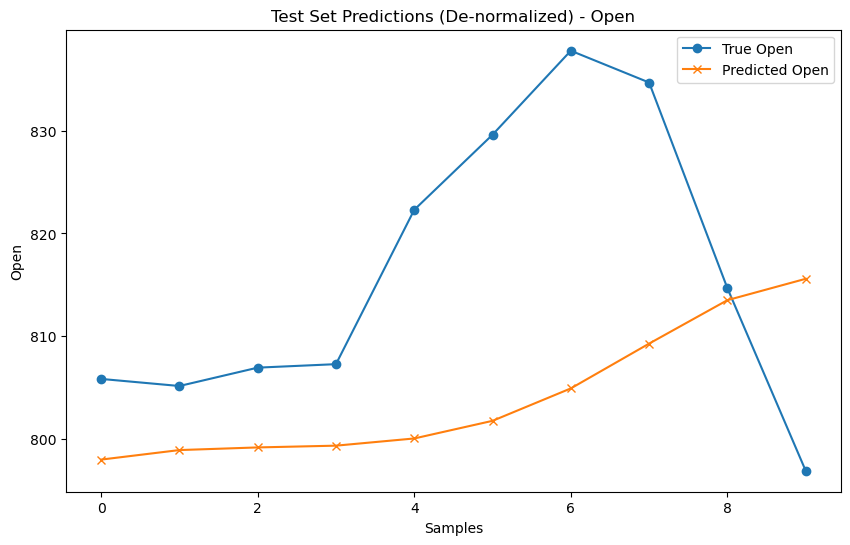

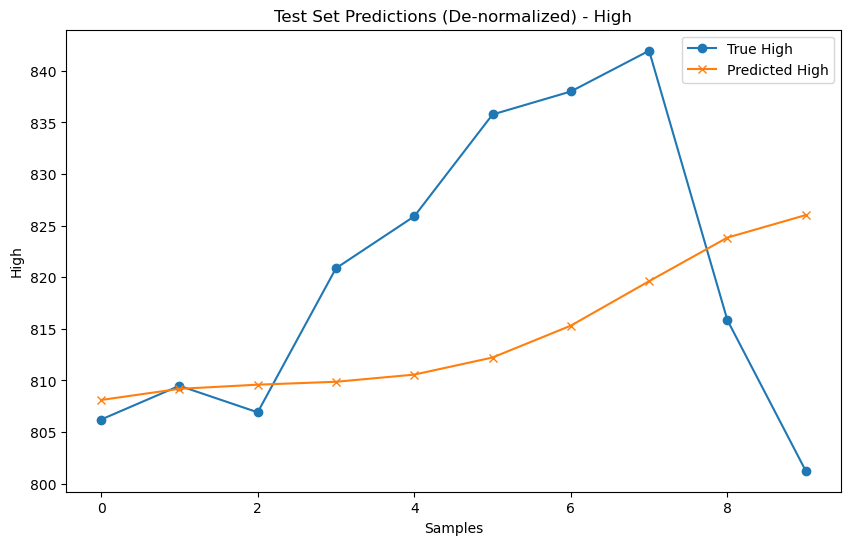

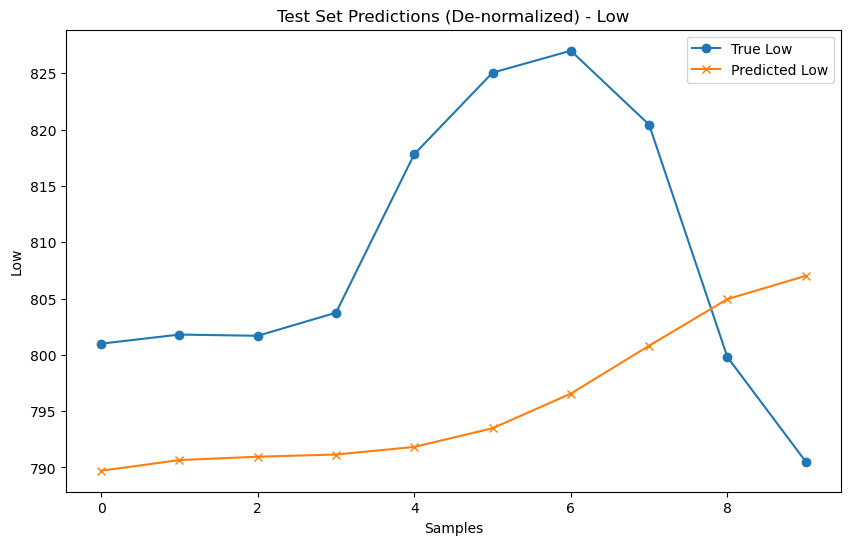

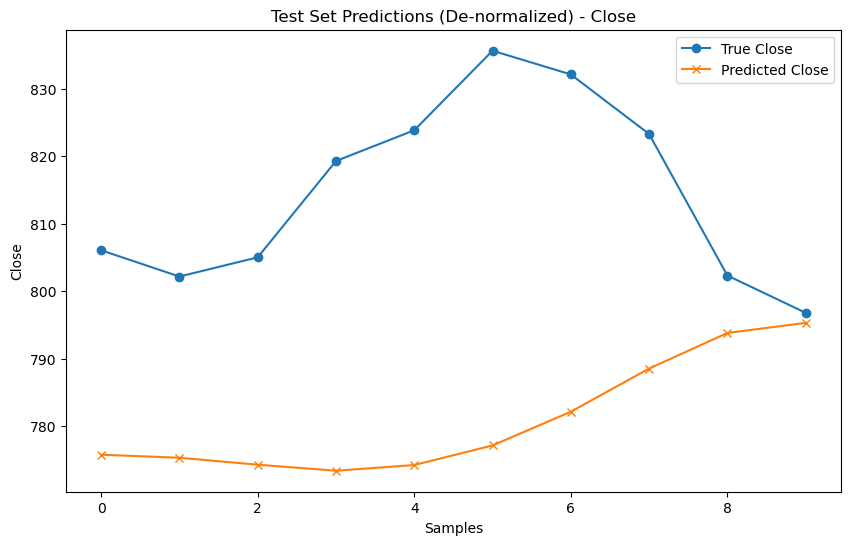

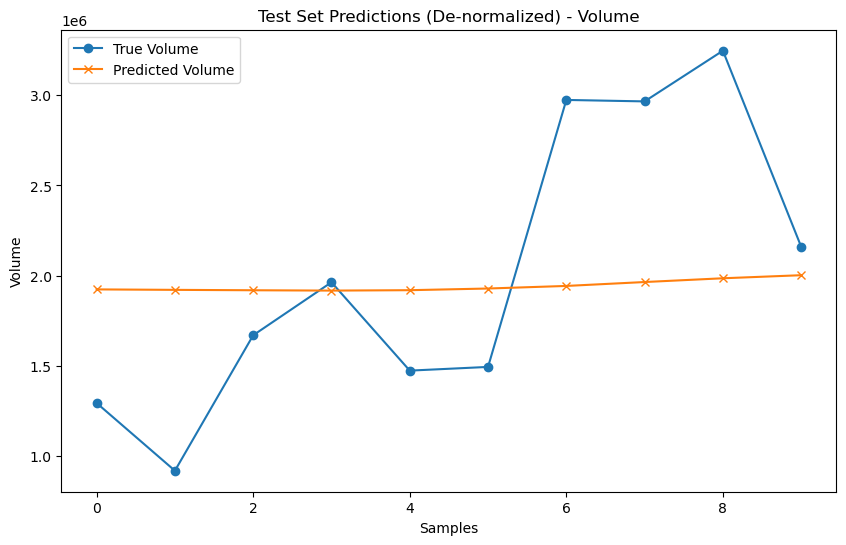

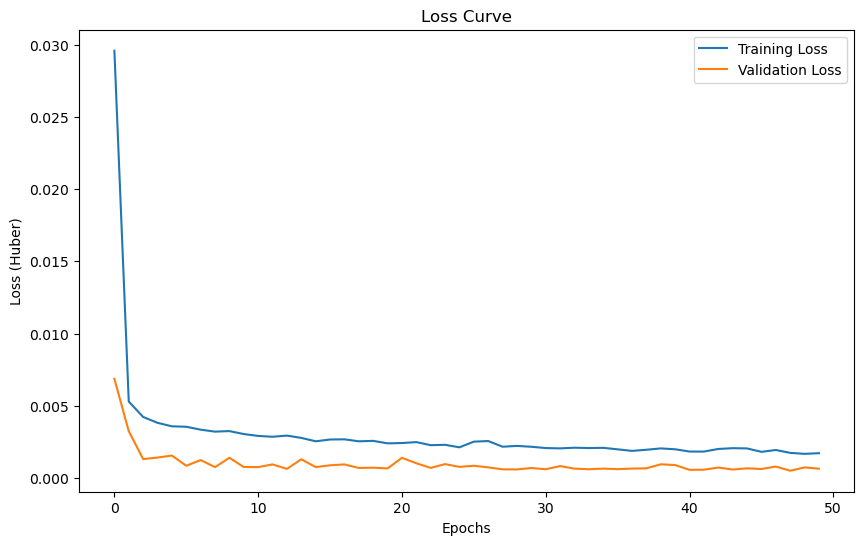

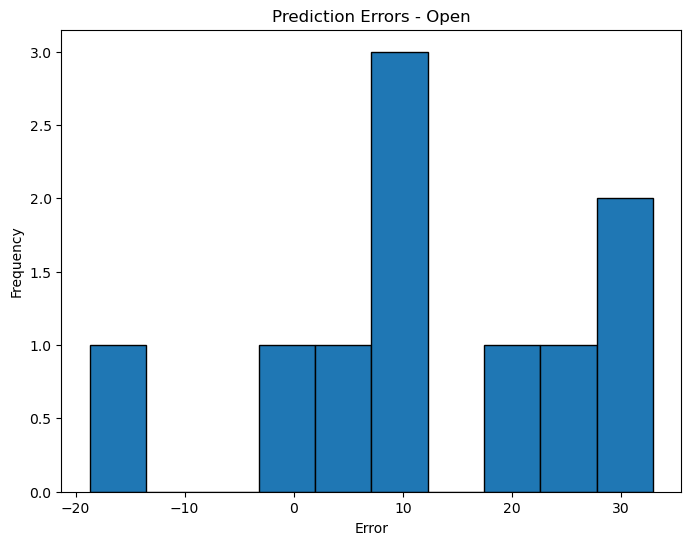

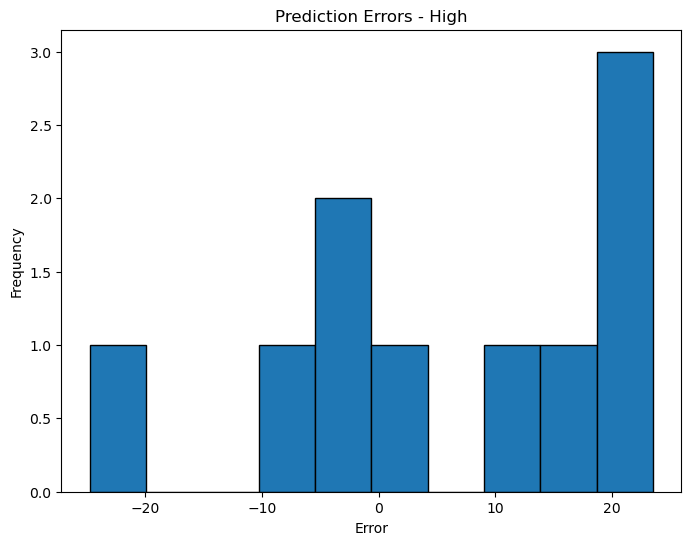

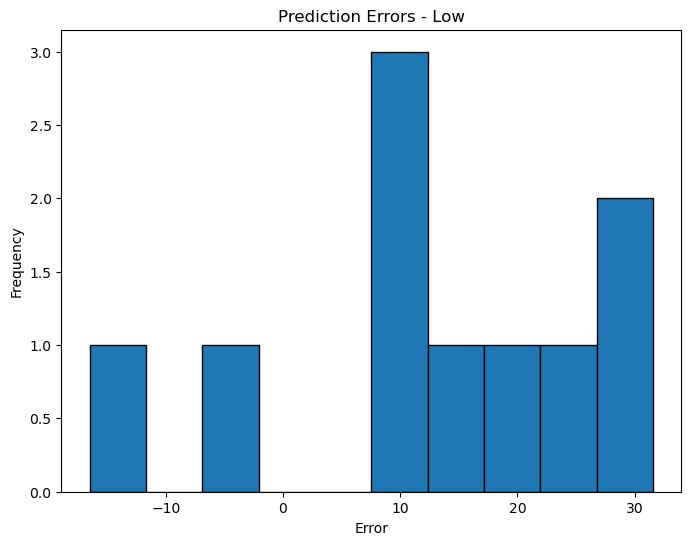

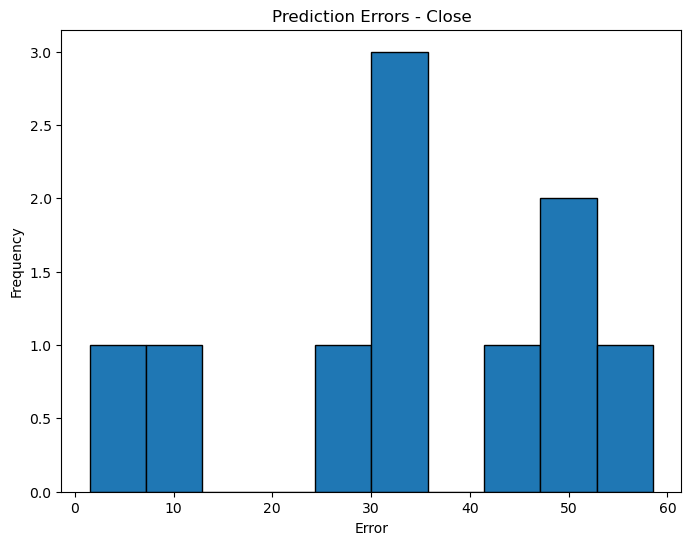

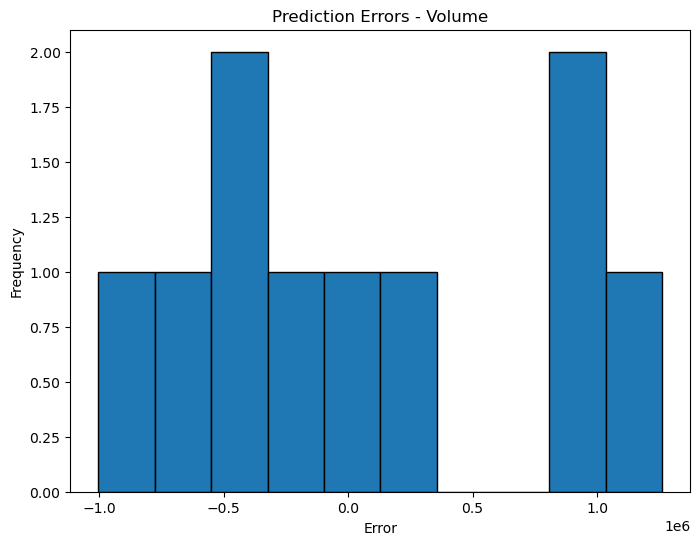

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# 1. Load data
train_file = "Google_Stock_Price_Train.csv"
test_file = "Google_Stock_Price_Test.csv"

# Load datasets
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Data preprocessing
features = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in features:
    train_data[col] = train_data[col].replace(',', '', regex=True).astype(float)
    test_data[col] = test_data[col].replace(',', '', regex=True).astype(float)

# Extract features and targets
X_train = train_data[features].values
y_train = train_data[features].values  # Targets include all features
X_test = test_data[features].values
y_test = test_data[features].values

# Split the training set into training and validation sets
train_size = int(len(X_train) * 0.8)
X_train_raw = X_train[:train_size]
y_train_raw = y_train[:train_size]
X_val_raw = X_train[train_size:]
y_val_raw = y_train[train_size:]

print(f"Train raw size: {len(X_train_raw)}, Val raw size: {len(X_val_raw)}, Test raw size: {len(X_test)}")

# Set time window for sequence generation
time_steps = 10

# Normalize data
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_raw)
X_val_scaled = feature_scaler.transform(X_val_raw)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train_raw)
y_val_scaled = target_scaler.transform(y_val_raw)
y_test_scaled = target_scaler.transform(y_test)

# 2. Define a function to generate time-series data
def create_time_series(data, labels, time_steps):
    if len(data) <= time_steps:
        raise ValueError(f"Data size ({len(data)}) is too small for time_steps ({time_steps}).")
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(labels[i])
    return np.array(X), np.array(y)

# Generate time-series data
X_train_seq, y_train_seq = create_time_series(X_train_scaled, y_train_scaled, time_steps)
X_val_seq, y_val_seq = create_time_series(X_val_scaled, y_val_scaled, time_steps)
X_test_seq, y_test_seq = create_time_series(X_test_scaled, y_test_scaled, time_steps)

print(f"Training Set X: {X_train_seq.shape}, Validation Set X: {X_val_seq.shape}, Testing Set X: {X_test_seq.shape}")

# 3. Build the model
model = Sequential([
    LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),

    LSTM(units=50, activation='tanh', return_sequences=True),
    Dropout(0.2),

    LSTM(units=50, activation='tanh', return_sequences=False),
    Dropout(0.2),

    Dense(len(features), activation='linear')  # Output layer predicting all features
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber())
model.summary()

# 4. Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

# 5. Evaluate and make predictions
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"\nTest Loss (Huber): {test_loss}")

# De-normalize predictions
y_pred = model.predict(X_test_seq)
y_pred_actual = target_scaler.inverse_transform(y_pred)
y_test_actual = target_scaler.inverse_transform(y_test_seq)

# 6. Visualize predictions
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual[:, i], label=f'True {feature}', marker='o')
    plt.plot(y_pred_actual[:, i], label=f'Predicted {feature}', marker='x')
    plt.title(f'Test Set Predictions (De-normalized) - {feature}')
    plt.xlabel('Samples')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

# 7. Visualize training process
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Huber)')
plt.legend()
plt.show()

# 8. Visualize error distribution
errors = y_test_actual - y_pred_actual
for i, feature in enumerate(features):
    plt.figure(figsize=(8, 6))
    plt.hist(errors[:, i], bins=10, edgecolor='black')
    plt.title(f'Prediction Errors - {feature}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()
